In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

### Установка необходимых пакетов / загрузка библиотек

> Successfully installed xgboost-1.6.1

> Successfully installed lightgbm-3.3.2

> Successfully installed catboost-1.0.6

In [51]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier

from catboost import CatBoostClassifier as catb
import xgboost as xgb, lightgbm as lgbm

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Подготовка функций для работы с данными

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (8, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title = 'Importance of features'
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [33]:
# присвоение значений из большего класса меньшему
def join_minor_class_to_major(feature_name, minor_name, major_name, df):
    df.loc[df[feature_name] == minor_name, feature_name] = major_name

In [36]:
# заменить значения выбросов на медиану
def outliers_to_median(feature_name, df):
    df.loc[df[feature_name] > df[feature_name].quantile(.9997), feature_name] = df[feature_name].median()

In [67]:
def find_null_values(df):
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        if pct_missing > 0:
            print('{} ~ {}%'.format(col, round(pct_missing*100)))

### Загрузка данных (EDA)

In [8]:
# Input:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

# Output:
SAMPLE_SUBMIT_PATH = './BBurtsev_predictions.csv'

# Usefull vars:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = []
NUM_FEATURE_NAMES = []
CAT_FEATURE_NAMES = []

#### Данные обучения:

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


In [10]:
train_df.shape

(7500, 17)

**Описание датасета:**

1. **Home Ownership** - вид домовладения
2. **Annual Income** - годовой доход
3. **Years in current job** - количество лет на текущем месте работы
4. **Tax Liens** - налоговые обременения
5. **Number of Open Accounts** - количество открытых счетов
6. **Years of Credit History** - количество лет кредитной истории
7. **Maximum Open Credit** - максимальный размер открытого кредита
8. **Number of Credit Problems** - количество проблем с кредитом
9. **Months since last delinquent** - количество месяцев с последней просрочки платежа
10. **Bankruptcies** - число банкротств
11. **Purpose** - цель кредита
12. **Term** - срок кредита
13. **Current Loan Amount** - текущая сумма кредита
14. **Current Credit Balance** - текущий кредитный баланс
15. **Monthly Debt** - ежемесячный платёж
16. **Credit Score** - индекс кредитоспособности

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Целевая переменная:**

- <font color='red'>**Credit Default**</font> - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [12]:
# Распределение целевой переменной (нормализованное):
train_df[TARGET_NAME].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

> Доля объектов целевого объекта ~ 28%

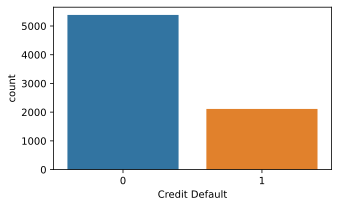

In [13]:
# Визуализация:
plt.figure(figsize=(5, 3))
sns.countplot(x=TARGET_NAME, data=train_df)
plt.show()

#### Данные тестирования:

In [14]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0


In [15]:
test_df.shape

(2500, 16)

In [16]:
# объединяю категориальные признаки в список + обзор категориальных признаков:
for cat_colname in train_df.select_dtypes(include='object').columns:
    CAT_FEATURE_NAMES.append(cat_colname)
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n\n' + '*' * 100 + '\n')
print(CAT_FEATURE_NAMES)

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation

In [17]:
# объединяю количественные признаки в список:
for num_colname in train_df.select_dtypes(exclude='object').columns:
    if num_colname == TARGET_NAME:
        continue
    NUM_FEATURE_NAMES.append(num_colname)
print(NUM_FEATURE_NAMES)

['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']


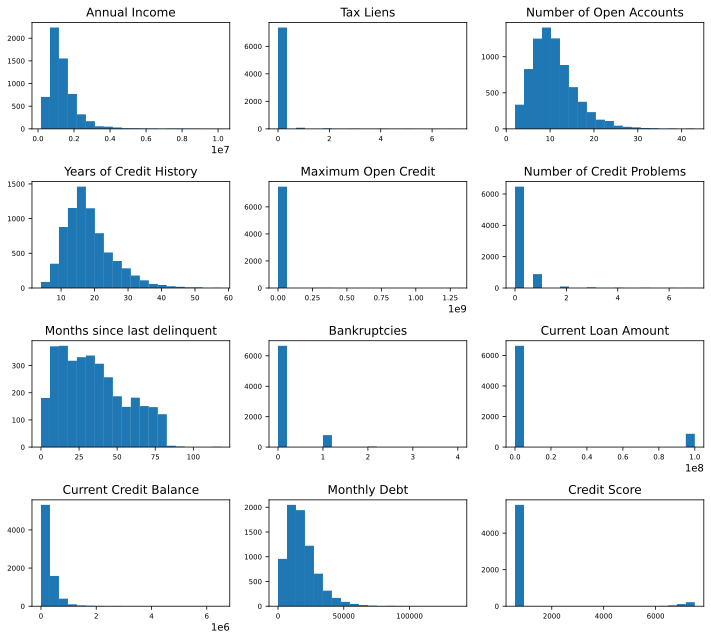

In [18]:
# визуальное отображение количественных фичей:
train_df[NUM_FEATURE_NAMES].hist(figsize=(10, 9), bins=20, grid=False, xlabelsize=7, ylabelsize=7, layout=(4, 3))
plt.tight_layout()
plt.show()

In [19]:
pd.options.display.float_format = '{:,.3f}'.format # запретить exp и отображать float до 3-го знака после запятой
train_df[NUM_FEATURE_NAMES].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,"5,943.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","3,419.000","7,486.000","7,500.000","7,500.000","7,500.000","5,943.000"
mean,"1,366,391.720",0.030,11.131,18.317,"945,153.727",0.170,34.693,0.117,"11,873,177.445","289,833.235","18,314.454","1,151.087"
std,"845,339.200",0.272,4.909,7.042,"16,026,216.671",0.499,21.689,0.347,"31,926,122.975","317,871.382","11,926.765","1,604.451"
min,"164,597.000",0.000,2.000,4.000,0.000,0.000,0.000,0.000,"11,242.000",0.000,0.000,585.000
25%,"844,341.000",0.000,8.000,13.500,"279,229.500",0.000,16.000,0.000,"180,169.000","114,256.500","10,067.500",711.000
50%,"1,168,386.000",0.000,10.000,17.000,"478,159.000",0.000,32.000,0.000,"309,573.000","209,323.000","16,076.500",731.000
75%,"1,640,137.000",0.000,14.000,21.800,"793,501.500",0.000,50.000,0.000,"519,882.000","360,406.250","23,818.000",743.000
max,"10,149,344.000",7.000,43.000,57.700,"1,304,726,170.000",7.000,118.000,4.000,"99,999,999.000","6,506,797.000","136,679.000","7,510.000"


#### Матрица корреляции

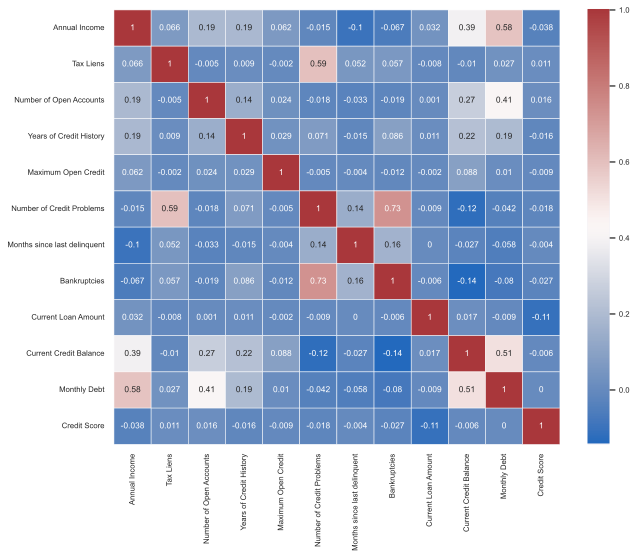

In [28]:
plt.figure(figsize=(10,8))

sns.set(font_scale=0.7)
sns.heatmap(train_df[NUM_FEATURE_NAMES].corr().round(3), color='white', annot=True, linewidth=.5, cmap='vlag')

plt.show()

#### Поиск выбросов

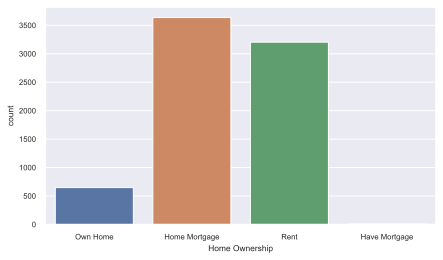

In [29]:
# Home ownership:
plt.figure(figsize=(7,4))

sns.countplot(x='Home Ownership', data=train_df)

plt.show()

#### Обработка выбросов

In [34]:
# Home Ownership
# Вхождения значения признака Home Ownership Have Mortgage следует объединить в Home Mortgage
# Они несут одну и ту же информацию по сути, а также признак Have Mortgage крайне редкий
join_minor_class_to_major(feature_name='Home Ownership', minor_name='Have Mortgage', major_name='Home Mortgage', df=train_df)

#### Обработка пропусков

In [68]:
find_null_values(train_df)

Annual Income ~ 21%
Years in current job ~ 5%
Months since last delinquent ~ 54%
Bankruptcies ~ 0%
Credit Score ~ 21%


In [38]:
len(train_df) - train_df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

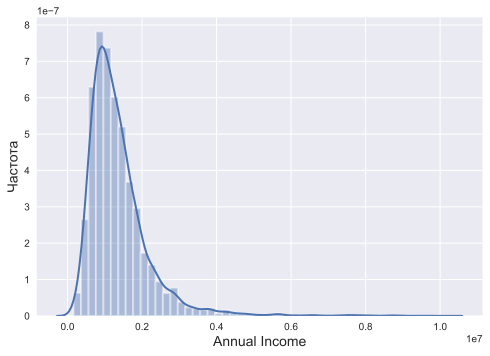

In [94]:
# histogram and kernel density estimation function of the variable height
ax = sns.distplot(train_df['Annual Income'], hist_kws={"edgecolor": 'w', "linewidth": 2}, kde_kws={"linewidth": 2})

# labels and title
plt.xlabel('Annual Income', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title = 'Distribution of Annual Income'

In [95]:
train_df['Annual Income'].describe()

count        5,943.000
mean     1,366,391.720
std        845,339.200
min        164,597.000
25%        844,341.000
50%      1,168,386.000
75%      1,640,137.000
max     10,149,344.000
Name: Annual Income, dtype: float64